# Illustration of contour normalization

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import sys
sys.path.append('../')
from src.extract.phrases import extract_phrases_from_kern_file
from src.extract.phrases import extract_phrases_from_gabc_file
from src.contour import stream_to_contour
from helpers import cm2inch, title

from src.clusterability.dataset import Dataset

matplotlib.style.use('styles.mplstyle')

## Plot basic contour representations

In [2]:
def show_phrase(phrase, ys, show_legend=True):
    # Extract note durations etc
    notes = phrase.recurse().notes
    offsets = [float(n.offset) for n in notes]
    pitches = [n.pitch.ps for n in notes]
    durations = [n.quarterLength for n in notes]

    # Get normalized contour
    xs = np.linspace(0, 1, len(ys))
    norm_ys = ys

    # Plot Piano roll
    total_duration = phrase.quarterLength
    for offset, duration, pitch in zip(offsets, durations, pitches):
        height = 1
        bottom_left = (offset/total_duration, pitch - height/2)
        rect = patches.Rectangle(bottom_left, duration/total_duration - 0.01, height,
                                 facecolor='r', alpha=.4, label='piano roll')
        plt.gca().add_patch(rect)


    plt.plot(xs, norm_ys, 'k.--', lw=.5, ms=2, label='contour')
    plt.xlim(-.05, 1.05)
    plt.plot([-.05,1.05], [0,0], 'k:', lw=.5)
    
    plt.ylabel('pitch')
    plt.xlabel('position in phrase')

    if show_legend:
        # Legend: don't repeat labels
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())

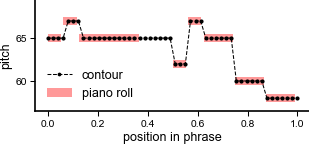

In [3]:
filepath = '../figures/fig-representations/nova005.krn'
phrase = extract_phrases_from_kern_file(filepath)[3]
contour = stream_to_contour(phrase)
ys = contour.interpolate(50).pitches

fig = plt.figure(figsize=cm2inch(6, 2.5))
show_phrase(phrase, ys, show_legend=True)
plt.ylim(-7 + ys.mean(), 6+ ys.mean())
plt.savefig('../figures/fig-representations/contour-creighton.pdf')

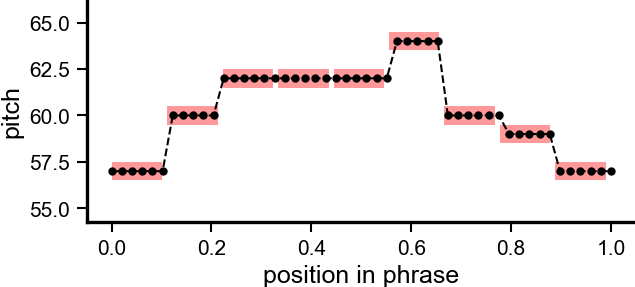

In [4]:
# Show a phrase from an antiphon
filepath = '../figures/fig-representations/00030.gabc'
phrase = extract_phrases_from_gabc_file(filepath)[0]
contour = stream_to_contour(phrase)
ys = contour.interpolate(50).pitches

fig = plt.figure(figsize=cm2inch(6,2.5))
show_phrase(phrase, ys, show_legend=False)
plt.ylim(-6 + ys.mean(), 6 + ys.mean())
plt.savefig('../figures/fig-representations/contour-exurge.pdf')

## All representations

In [5]:
creighton = Dataset('creighton-phrase')
match = creighton.df.query('song_id=="nova005" and unit_num==3')
contour_idx = creighton.df.index.get_indexer_for(match)[0]

In [6]:
def show_pitch_representations(dataset, contour_idx, ax0, ax1, ax2):
    title('Pitch', ax=ax0)
    phrase = dataset.representation('pitch')[contour_idx, :]
    ax0.plot(phrase, '.-', lw=1)
    ax0.set_ylabel('pitch')

    title('Transposed pitch representations', ax=ax1)
    phrase = dataset.representation('pitch_centered')[contour_idx, :]
    ax1.plot(phrase, lw=1, label='center')
    phrase = dataset.representation('pitch_tonicized')[contour_idx, :]
    ax1.plot(phrase, lw=1, label='tonic')
    phrase = dataset.representation('pitch_finalized')[contour_idx, :]
    ax1.plot(phrase, lw=1, label='final')
    ax1.legend(ncol=3)
    ax1.set_ylabel('transposed pitch')

    title('Normalized pitch', ax=ax2)
    phrase = dataset.representation('pitch_normalized')[contour_idx, :]
    ax2.plot(phrase, lw=1)
    ax2.set_xlabel('relative position')
    ax2.set_ylabel('normalized pitch')

# fig, axs = plt.subplots(3, figsize=cm2inch(6, 9), sharex=True, tight_layout=True)
# show_pitch_representations(creighton, contour_idx, *axs)

In [7]:
def show_relative_representations(dataset, contour_idx, ax):
    phrase = dataset.representation('interval')[contour_idx, :]
    ax.plot(phrase, '.-', lw=1, label='interval')

    phrase = creighton.representation('smooth_derivative')[contour_idx, :]
    ax.plot(phrase, '.-', lw=1, label='smooth derivative')

    ax.legend()
    ax.set_xlabel('relative position')
    ax.set_ylabel('interval')
    title('Relative representations', ax=ax)

# plt.figure(figsize=cm2inch(8, 4))
# show_relative_representations(creighton, contour_idx, plt.gca())

In [8]:
def show_cosine_representation(dataset, contour_idx, ax):
    phrase = dataset.representation('cosine')[contour_idx, :]
    ax.plot(phrase, '.-', lw=1)
    ax.set_xlabel('frequency')
    ax.set_ylabel('intensity')
    title('Cosine contour', ax=ax)

# plt.figure(figsize=cm2inch(6, 3))
# show_cosine_representation(creighton, contour_idx, plt.gca())

../src/clusterability/representations.py:49: RuntimeWarning: invalid value encountered in true_divide
  normalized = (contours - minima) / (maxima - minima)


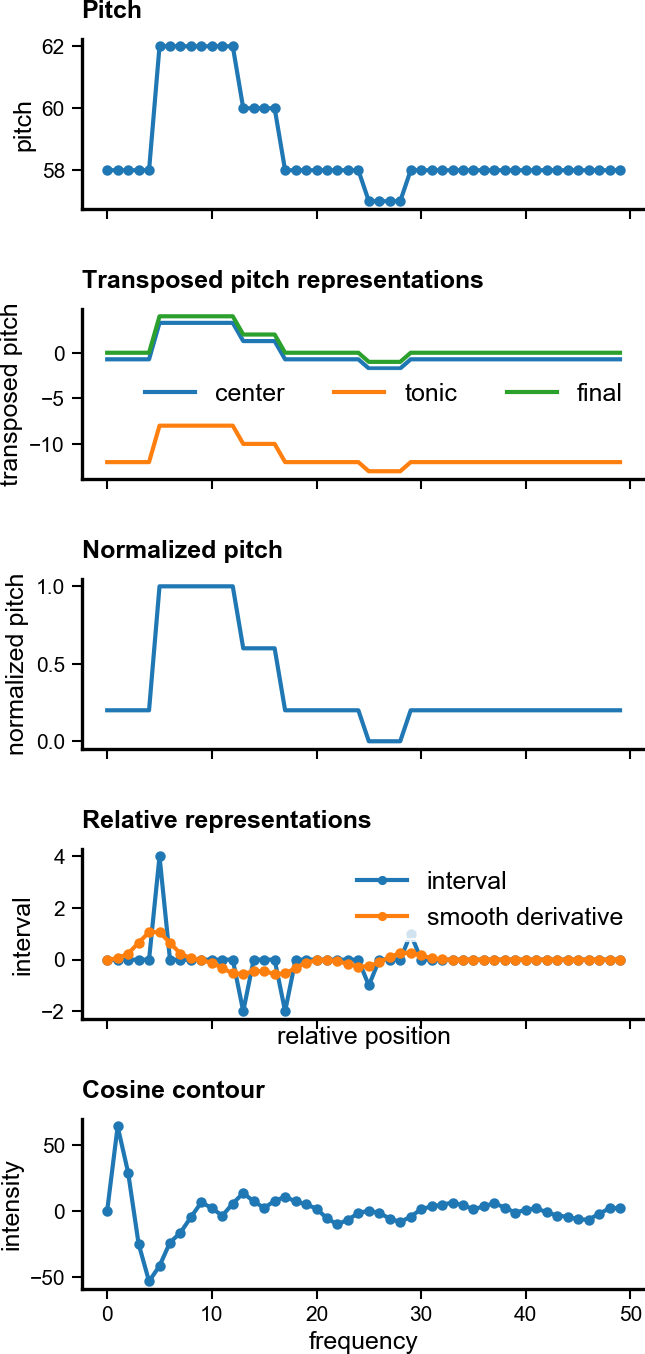

In [9]:
fig, axs = plt.subplots(5, figsize=cm2inch(6, 12), sharex=True, tight_layout=True)
show_pitch_representations(creighton, contour_idx, *axs[:3])
show_relative_representations(creighton, contour_idx, axs[3])
show_cosine_representation(creighton, contour_idx, axs[4])
axs[2].set_xlabel(None)
plt.savefig('../figures/fig-representations/all-representation.pdf')

### Sanity check: inverse operations

As a sanity check we compute the 'inverse operations' of the
cosine and relative representations. If we take the inverse discrete cosine transform of a cosine contour, we get the original contour back. Similarly, we retrieve the original contour by taking the cumulative sum of an interval representation. For the smooth derivative we only approximate the contour, because of the smoothing.

In [30]:
from scipy.fft import idct

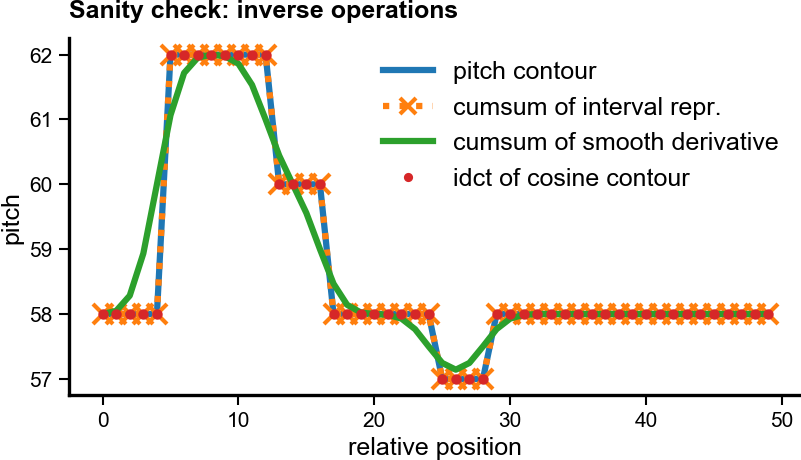

In [42]:
intervals = creighton.representation('interval')[contour_idx]
smooth_int = creighton.representation('smooth_derivative')[contour_idx]
cosine = creighton.representation('cosine')[contour_idx]
pitches = creighton.representation('pitch')[contour_idx] 

plt.figure(figsize=cm2inch(8, 4))
plt.plot(pitches, label='pitch contour')
plt.plot(pitches[0] + np.cumsum(intervals), "x:", label='cumsum of interval repr.', ms=5)
plt.plot(pitches[0] + np.cumsum(smooth_int), label='cumsum of smooth derivative')
plt.plot(pitches.mean() + idct(cosine), '.', label='idct of cosine contour')

plt.legend()
plt.xlabel('relative position')
plt.ylabel('pitch')
title('Sanity check: inverse operations')